In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jupyter_black

jupyter_black.load()

In [3]:
import numpy as np

from acoustics.constants import (
    air_density_at_0,
    gamma,
    gas_constant,
    one_atmosphere,
    speed_of_sound,
)
from acoustics.plot import plot

## Rigid Backed Porous Absorber

These are the generic absorbers commonly shown in DYI build vidoes and posts. They are also offered for sale by various companies, e.g. https://www.musiccityacoustics.com/.

* https://github.com/ChrisWhealy/porous_absorber/blob/master/src/calc_engine/perforated_panel.rs#L122
* links to excell Porous Absorber Calculator V1.60 Office 365
* https://gearspace.com/board/studio-building-acoustics/625978-common-gas-flow-resistivity-numbers.html
* https://docs.google.com/spreadsheets/d/19q-20qTpKV5g12PiSc1gNrJlG8DYrtqaFeFoYUCxC68/edit#gid=861262967

In [4]:
def porous_absorber(
    frequencies,
    sigma,
    thickness,
    air_gap,
    angle=0,
    air_temperature=20.0,
    atmospheric_pressure=1.0,
):

    w = 2.0 * np.pi * frequencies
    two_pi_over_c = 2 * np.pi / speed_of_sound
    kair = two_pi_over_c * frequencies
    air_density = (atmospheric_pressure * one_atmosphere) / (
        gas_constant * (273.15 + air_temperature)
    )
    X = (air_density * frequencies) / sigma
    sound_velocity = np.sqrt((gamma * one_atmosphere) / air_density_at_0) * np.sqrt(
        1 + (air_temperature / 273.15)
    )
    air_impedance = sound_velocity * air_density
    zca = air_impedance * (
        1 + 0.0571 * np.power(X, -0.754) + -0.087j * np.power(X, -0.732)
    )
    k = (
        two_pi_over_c
        * frequencies
        * (1 + 0.0978 * np.power(X, -0.7) + -0.189j * np.power(X, -0.595))
    )
    ky = kair * np.sin(angle * np.pi / 180)
    kx = np.sqrt(k * k - ky * ky)
    bporous = np.arcsin(np.abs(ky / k)) * 180 / np.pi
    k_kx = k / kx
    cot_k_times_ta = np.cos(k * thickness) / np.sin(k * thickness)
    if air_gap == 0:
        # no air gap
        zsa = -1j * zca * k_kx * cot_k_times_ta
        zsa_over_rc_times_cos_y = (zsa / air_impedance) * np.cos(angle * np.pi / 180)
        reflection_factor = (zsa_over_rc_times_cos_y - 1) / (
            zsa_over_rc_times_cos_y + 1
        )
        a = 1 - np.power(np.abs(reflection_factor), 2)
        #             pprint({
        #                 'w': w,
        #                 'kair': kair,
        #                 'X': X,
        #                 'zca': zca,
        #                 'k': k,
        #                 'ky': ky,
        #                 'kx': kx,
        #                 'bporous': bporous,
        #                 'k_kx': k_kx,
        #                 'cot_k_times_ta': cot_k_times_ta,
        #                 'zsa': zsa,
        #                 'zsa_over_rc_times_cos_y': zsa_over_rc_times_cos_y,
        #                 'reflection_factor': reflection_factor,
        #                 'a': a,
        #             })
        return a

    # air gap
    kair_y = k * np.sin(bporous * np.pi / 180)
    kair_x = np.sqrt(np.power(kair, 2) - (kair_y * kair_y))
    bair = np.arcsin(np.abs((kair_y / air_impedance))) * 180 / np.pi
    kair_over_kair_x = kair / kair_x
    zair = (
        -1j
        * air_impedance
        * kair_over_kair_x
        * np.cos(kair * air_gap)
        / np.sin(kair * air_gap)
    )
    inter = -1j * zca * cot_k_times_ta
    za_air = ((inter * zair) + (zca * zca)) / (zair + inter)
    inter2 = (za_air / air_impedance) * np.cos(angle * np.pi / 180)
    overall_reflection_factor = (inter2 - 1) / (inter2 + 1)
    a = 1 - np.power(np.abs(overall_reflection_factor), 2)
    #         pprint({
    #             'w': w,
    #             'kair': kair,
    #             'X': X,
    #             'zca': zca,
    #             'k': k,
    #             'ky': ky,
    #             'kx': kx,
    #             'bporous': bporous,
    #             'k_kx': k_kx,
    #             'cot_k_times_ta': cot_k_times_ta,
    #             'kair_y': kair_y,
    #             'kair_x': kair_x,
    #             'bair': bair,
    #             'kair_over_kair_x': kair_over_kair_x,
    #             'zair': zair,
    #             'inter': inter,
    #             'za_air': za_air,
    #             'inter2': inter2,
    #             'overall_reflection_factor': overall_reflection_factor,
    #             'a': a,
    #         })
    return a

In [5]:
# the frequencies over which to run the calculations
f = np.arange(15, 20000, 1)

## Flow Resisitivity (sigma)

Different theoretical porous absorbent materials

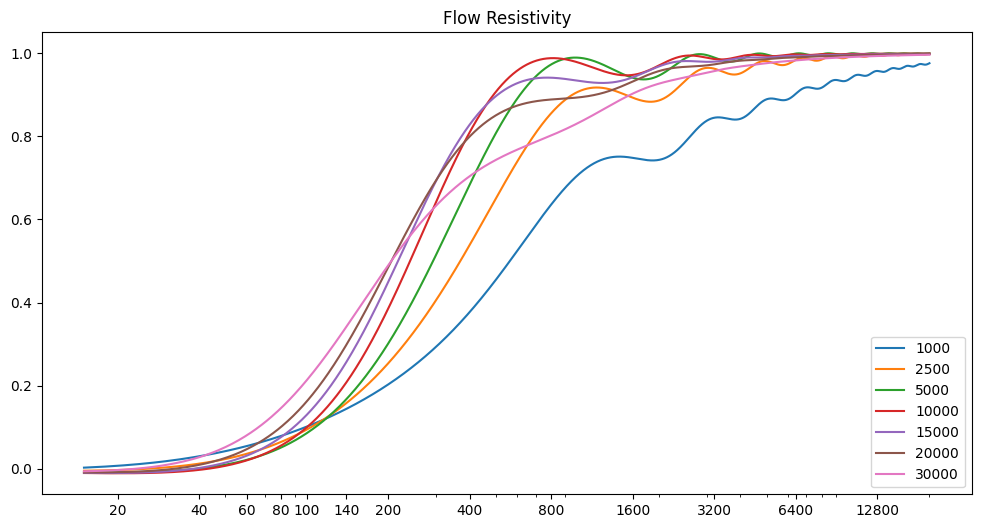

In [6]:
ax = plot(
    f,
    {
        f"{s}": porous_absorber(f, sigma=s, thickness=0.0254 * 3.5, air_gap=0, angle=0)
        for s in (1000, 2500, 5000, 10000, 15000, 20000, 30000)
    },
    title="Flow Resistivity",
    loc="lower right",
)

## Angle of Incidence

The angle at which sound arrives impacts the effectiveness of the absorber. 

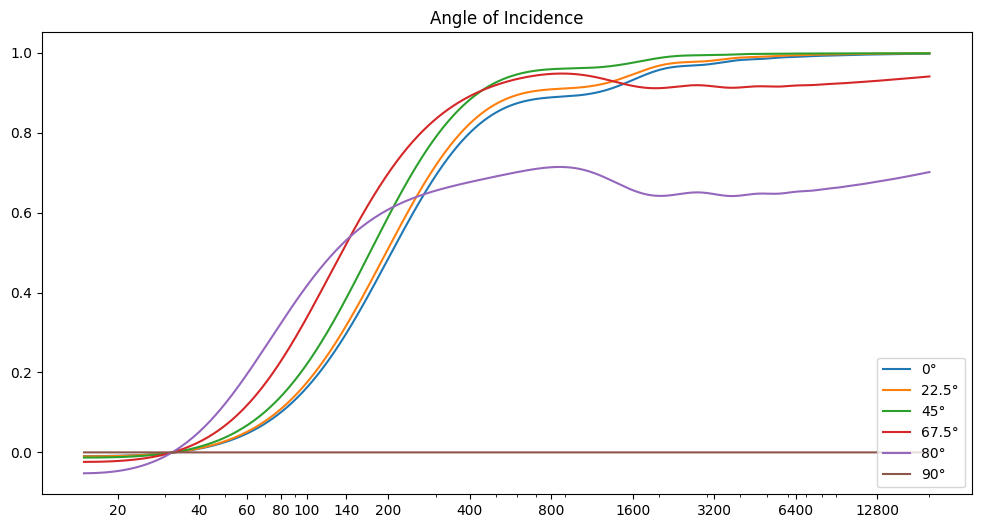

In [7]:
ax = plot(
    f,
    {
        f"{a}°": porous_absorber(
            f, sigma=20000, thickness=0.0254 * 3.5, air_gap=0, angle=a
        )
        for a in (0, 22.5, 45, 67.5, 80, 90)
    },
    title="Angle of Incidence",
    loc="lower right",
)

## Thickness

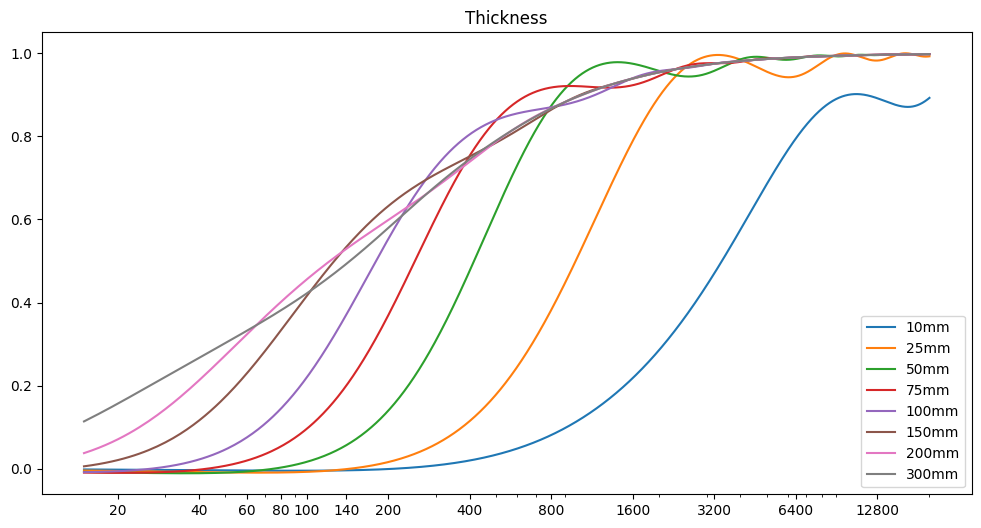

In [11]:
ax = plot(
    f,
    {
        f"{t*1000:.0f}mm": porous_absorber(
            f, sigma=20000, thickness=t, air_gap=0, angle=0
        )
        for t in (0.01, 0.0254, 0.050, 0.075, 0.1, 0.15, 0.2, 0.3)
    },
    title="Thickness",
    loc="lower right",
)

## Air Gap

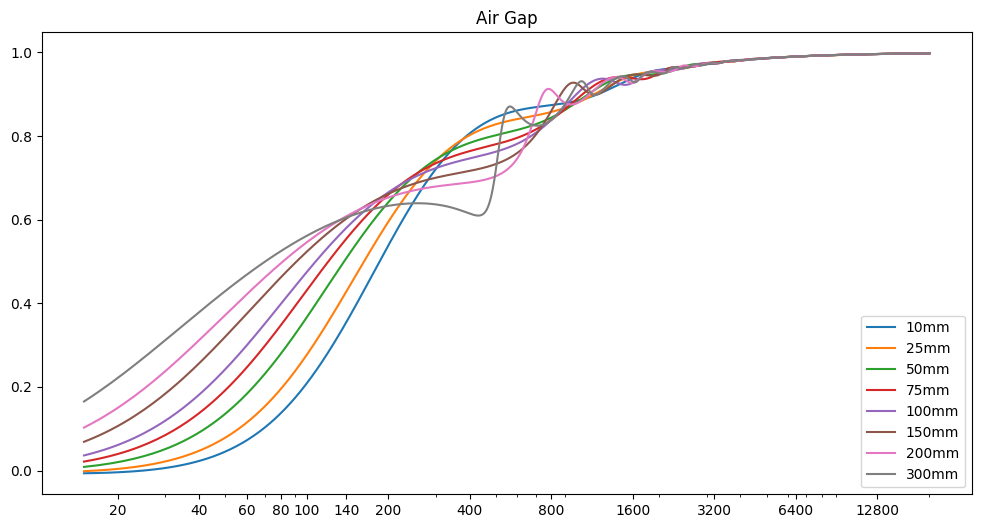

In [12]:
ax = plot(
    f,
    {
        f"{g*1000:.0f}mm": porous_absorber(
            f, sigma=20000, thickness=0.0254 * 3.5, air_gap=g, angle=0
        )
        for g in (0.01, 0.0254, 0.050, 0.075, 0.1, 0.15, 0.2, 0.3)
    },
    title="Air Gap",
    loc="lower right",
)

# Real World Materials

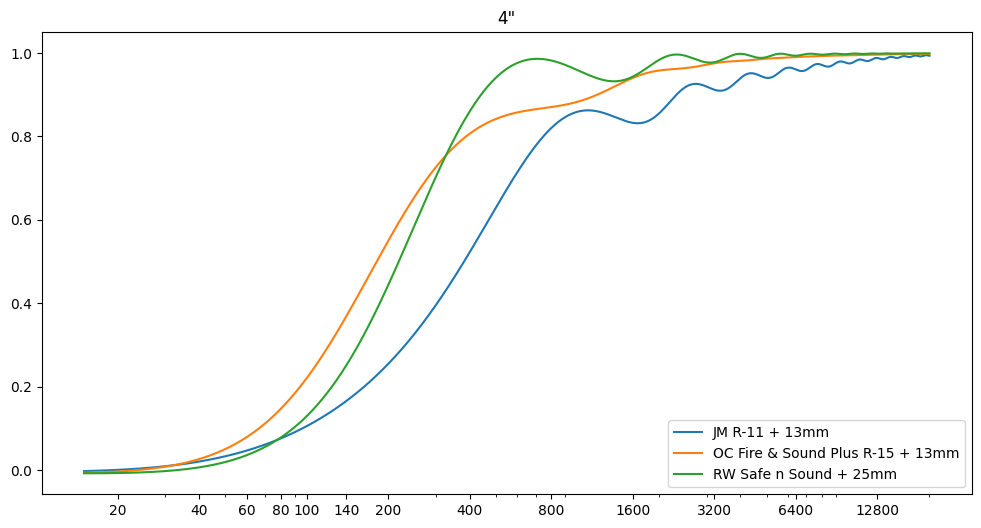

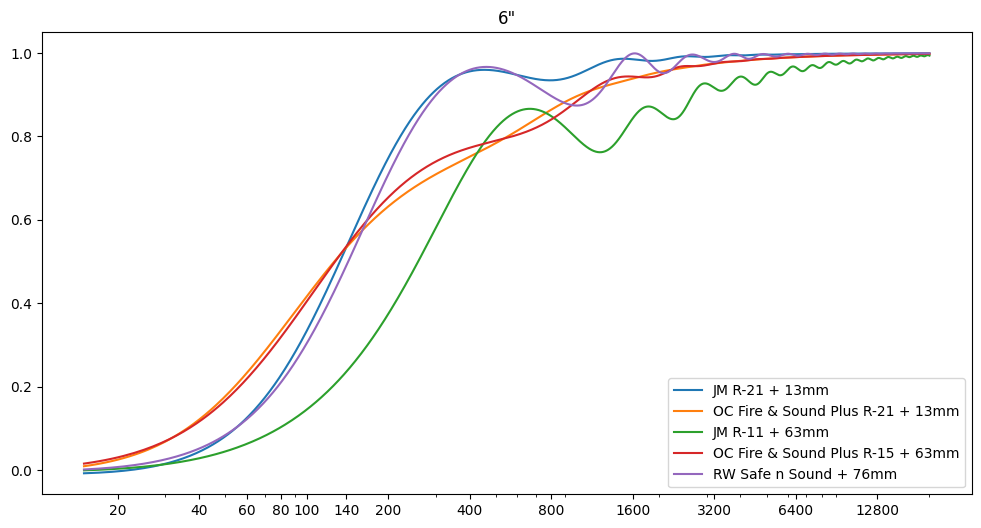

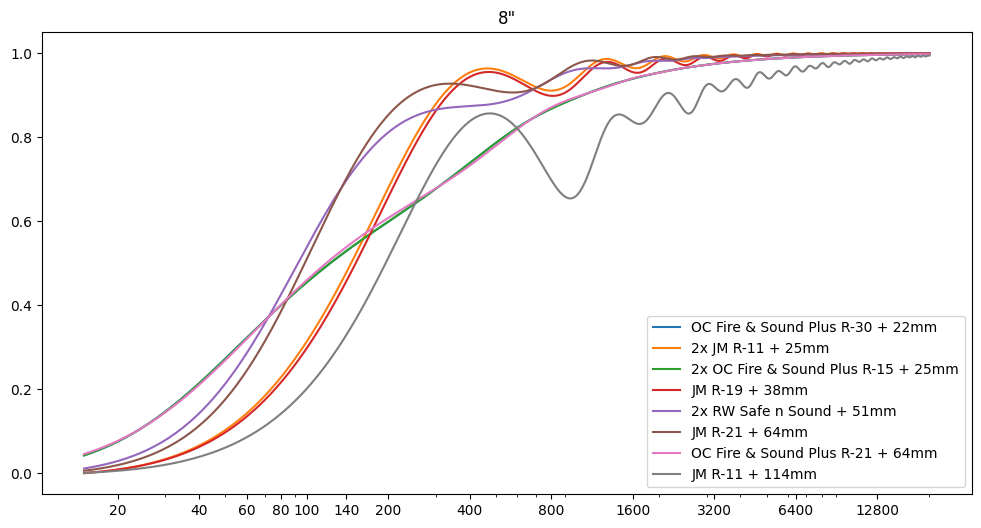

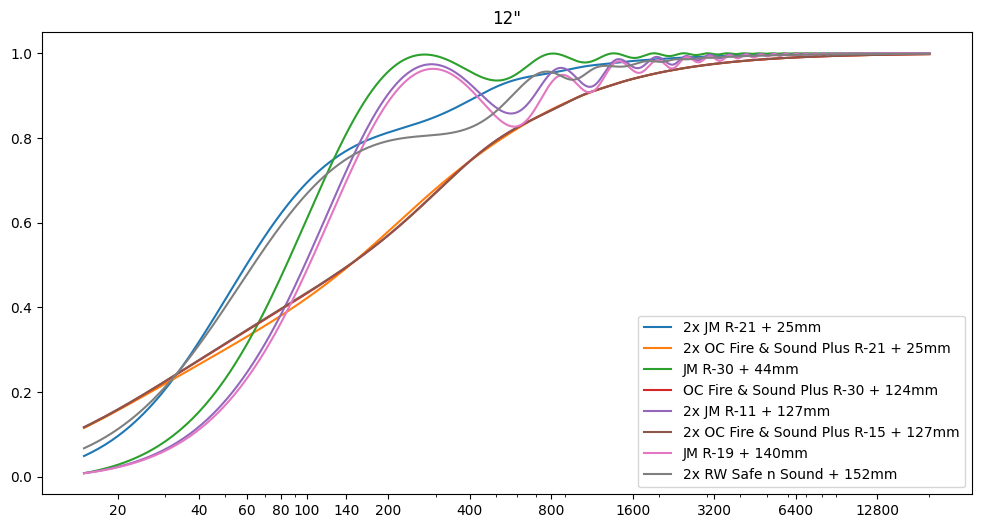

In [10]:
# https://docs.google.com/spreadsheets/d/19q-20qTpKV5g12PiSc1gNrJlG8DYrtqaFeFoYUCxC68/edit#gid=861262967
materials = {
    "JM R-11": {
        "sigma": 1720,
        "thickness": 3.5 * 0.0254,
    },
    "JM R-19": {
        "sigma": 1674,
        "thickness": 6.5 * 0.0254,
    },
    "JM R-21": {
        "sigma": 7901,
        "thickness": 5.5 * 0.0254,
    },
    "JM R-30": {
        "sigma": 1850,
        "thickness": 10.25 * 0.0254,
    },
    "RW Safe n Sound": {
        "sigma": 10000,
        "thickness": 3 * 0.0254,
    },
    "OC Fire & Sound Plus R-15": {
        "sigma": 20000,
        "thickness": 3.5 * 0.0254,
    },
    "OC Fire & Sound Plus R-21": {
        "sigma": 20000,
        "thickness": 5.5 * 0.0254,
    },
    "OC Fire & Sound Plus R-30": {
        "sigma": 20000,
        "thickness": 7.125 * 0.0254,
    },
}

for depth in (4, 6, 8, 12):
    depth *= 0.0254
    configs = []
    for name, info in materials.items():
        thickness = info["thickness"]
        i = 1
        while thickness < depth:
            air_gap = depth - thickness
            a = porous_absorber(
                f, sigma=info["sigma"], thickness=thickness, air_gap=air_gap
            )
            if i == 1:
                label = name
            else:
                label = f"{i}x {name}"
            configs.append((f"{label} + {air_gap*1000:.0f}mm", a, thickness / depth))
            thickness += thickness
            i += 1

    configs.sort(key=lambda d: d[2], reverse=True)
    configs = {c[0]: c[1] for c in configs[:8]}

    plot(f, configs, title=f'{depth / 0.0254:.0f}"', loc="lower right")